In [1]:
import tensorflow as tf
from keras import layers, models
import numpy as np
import cv2
import os
from skimage import io, color
import os
import matplotlib.pyplot as plt
import random
from skimage import transform
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from keras.models import load_model


2024-12-10 10:40:10.598694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 10:40:10.612685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 10:40:10.616831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 10:40:10.627673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# load dataset

In [6]:
! wget http://images.cocodataset.org/zips/test2017.zip

--2024-12-10 10:25:44--  http://images.cocodataset.org/zips/test2017.zip
Résolution de images.cocodataset.org (images.cocodataset.org)… 52.216.217.9, 16.15.176.244, 3.5.21.203, ...
Connexion à images.cocodataset.org (images.cocodataset.org)|52.216.217.9|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 6646970404 (6,2G) [application/zip]
Enregistre : ‘test2017.zip’

test2017.zip          0%[                    ]  41,83M  6,39MB/s    tps 13m 12s^C


In [ ]:
! unzip test2017.zip -d coco_dataset

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: coco_dataset/test2017/000000251604.jpg  
 extracting: coco_dataset/test2017/000000145034.jpg  
 extracting: coco_dataset/test2017/000000234833.jpg  
 extracting: coco_dataset/test2017/000000025927.jpg  
 extracting: coco_dataset/test2017/000000393116.jpg  
 extracting: coco_dataset/test2017/000000536478.jpg  
 extracting: coco_dataset/test2017/000000365460.jpg  
 extracting: coco_dataset/test2017/000000089887.jpg  
 extracting: coco_dataset/test2017/000000274928.jpg  
 extracting: coco_dataset/test2017/000000310028.jpg  
 extracting: coco_dataset/test2017/000000229793.jpg  
 extracting: coco_dataset/test2017/000000394339.jpg  
 extracting: coco_dataset/test2017/000000564538.jpg  
 extracting: coco_dataset/test2017/000000440585.jpg  
 extracting: coco_dataset/test2017/000000541512.jpg  
 extracting: coco_dataset/test2017/000000395525.jpg  
 extracting: coco_dataset/test2017/000000235435.jpg  
 ext

In [ ]:
# %%bash

# # Define source and target directories
# SOURCE_DIR="coco_dataset/val2017/"
# TARGET_DIR="coco_dataset/val2017_subset/"
# # nb_imgs = 30000
# # Create the target directory if it doesn't exist
# mkdir -p "$TARGET_DIR"

# # Find the first 30,000 files in the source directory and move them to the target directory
# find "$SOURCE_DIR" -type f | head -n 30000 | while read file; do
#     mv "$file" "$TARGET_DIR"
# done

# echo "Moved the first 30000 images to $TARGET_DIR."


Moved the first 30000 images to coco_dataset/val2017_subset/.


In [ ]:
tf.config.list_physical_devices()

I0000 00:00:1733819755.207794 1030028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733819755.333283 1030028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733819755.333494 1030028 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from pathlib import Path

# data_dir = 'coco_dataset/val2017_subset/'
data_dir = 'coco_dataset/test2017/'

image_size = (256, 256)
batch_size = 8

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

def preprocess_for_colorization(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)

    return grayscale/255.0, image/255.0
def preprocess_with_mask(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(image.shape)
    height, width = image.shape[1], image.shape[2]

    # Create a binary mask with 1% of pixels randomly set to 1
    num_pixels = height * width
    num_hints = int(0.01 * num_pixels) 
    flat_indices = tf.random.shuffle(tf.range(num_pixels))[:num_hints]
    binary_mask = tf.scatter_nd(
        indices=tf.expand_dims(flat_indices, axis=1),
        updates=tf.ones_like(flat_indices, dtype=tf.float32),
        shape=(num_pixels,)
    )
    binary_mask = tf.reshape(binary_mask, (height, width))  # Reshape to 2D

    # Expand binary mask to 3 channels and apply it to the original image
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    color_mask = image * tf.cast(binary_mask, dtype=image.dtype)

    grayscale = grayscale / 255.0
    color_mask = color_mask / 255.0
    image = image / 255.0

    return (grayscale, color_mask), image

colorization_dataset = dataset.map(preprocess_for_colorization, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# colorization_dataset = dataset.map(preprocess_with_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)




Found 40670 files.


I0000 00:00:1733823627.768461 1137689 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733823627.804756 1137689 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733823627.805112 1137689 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733823627.806132 1137689 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

2024-12-10 10:25:27.024168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 599 of 1000
2024-12-10 10:25:29.395264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-12-10 10:25:29.512594: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


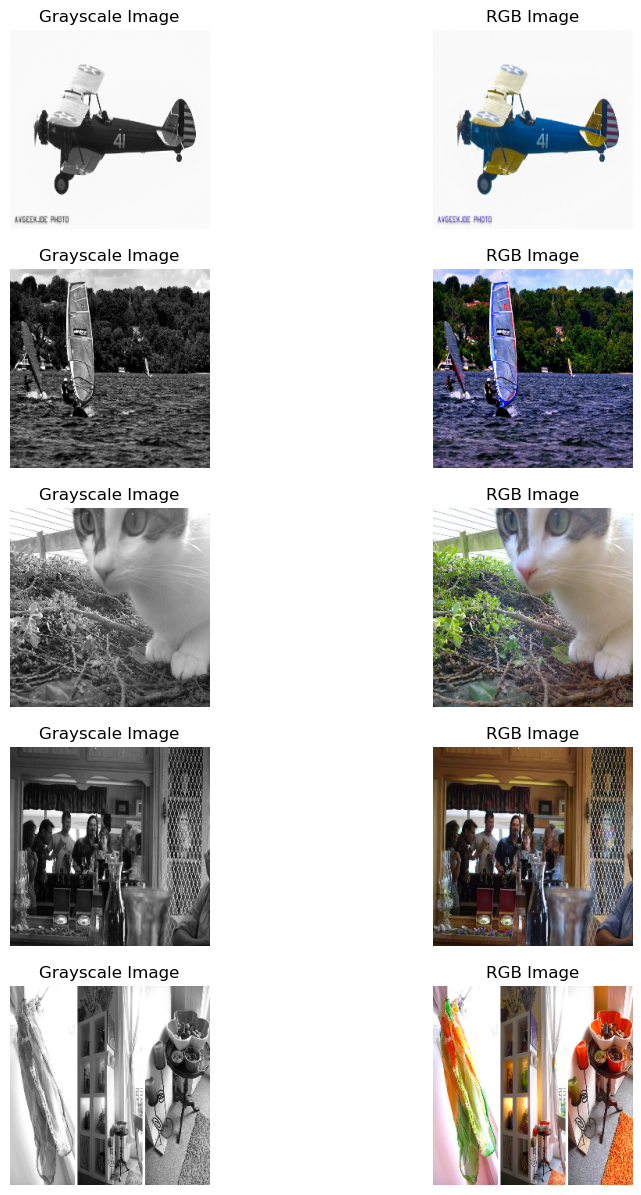

In [ ]:
def display_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(10, num_images * 3))
    count = 0
    for grayscale_batch, rgb_batch in dataset.take(1): 
        for i in range(num_images):
            if count >= len(grayscale_batch):  # Stop if fewer images than num_images in batch
                break
            grayscale_image = grayscale_batch[i].numpy().squeeze()  
            rgb_image = rgb_batch[i].numpy() 

            # Plot grayscale image
            plt.subplot(num_images, 2, 2 * count + 1)
            plt.imshow(grayscale_image, cmap='gray')
            plt.title("Grayscale Image")
            plt.axis("off")
            # Plot RGB image
            plt.subplot(num_images, 2, 2 * count + 2)
            plt.imshow(rgb_image)
            plt.title("RGB Image")
            plt.axis("off")

            count += 1
            if count >= num_images:
                break
    plt.show()

display_from_dataset(train_dataset, num_images=5)


In [ ]:
# print(train_dataset.take(1))
for batch in train_dataset.take(1):
    print("Shape des images:", len(batch[0]), len(batch[1]))

In [ ]:
print(dataset)
print(train_dataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>


# Base Model

In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, BatchNormalization, Input

def build_colorization_model(input_shape):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    print(input_shape)
    # Encoder
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

    # Decoder
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return model

from keras.applications import VGG19

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False  

feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv2').output)
def perceptual_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(feature_extractor(y_true) - feature_extractor(y_pred)))
    return loss

input_shape = (image_size[0], image_size[1], 1)  # Grayscale images have 1 channel
model = build_colorization_model(input_shape)

# Compile the model
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(optimizer='adam', loss = perceptual_loss, metrics=['mae'])

model.summary()


(256, 256, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,575,619 (17.45 MB)

 Trainable params: 4,575,619 (17.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import Callback

class SaveModelEveryNEpochs(Callback):
    def __init__(self, save_path, interval):
        super(SaveModelEveryNEpochs, self).__init__()
        self.save_path = save_path
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        # Save the model every 'interval' epochs
        if (epoch + 1) % self.interval == 0:
            save_path_with_epoch = f"{self.save_path}.keras"
            self.model.save(save_path_with_epoch)
            print(f"Model saved at {save_path_with_epoch}")

# Define the model save path and interval
save_path = "colorization_model_256x256_100epochs_perceptual_40000"
save_interval = 10

save_callback = SaveModelEveryNEpochs(save_path=save_path, interval=save_interval)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[save_callback]
)

Epoch 1/100


2024-12-10 10:42:25.098907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 593 of 1000
2024-12-10 10:42:27.516435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1733823747.524365 1138163 service.cc:146] XLA service 0x7de5ac009380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733823747.524470 1138163 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-10 10:42:27.715335: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 10:42:28.260503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2024-12-10 10:42:43.637138: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of m

   1/4068 ━━━━━━━━━━━━━━━━━━━━ 39:20:59 35s/step - loss: 0.8722 - mae: 0.2592

I0000 00:00:1733823766.621995 1138163 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3806/4068 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - loss: 0.4860 - mae: 0.2035

2024-12-10 10:55:10.322409: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-10 10:55:11.307802: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4068/4068 ━━━━━━━━━━━━━━━━━━━━ 932s 221ms/step - loss: 0.4748 - mae: 0.1997 - val_loss: 0.1952 - val_mae: 0.0999
Epoch 2/100


2024-12-10 10:57:53.774875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 889 of 1000


   1/4068 ━━━━━━━━━━━━━━━━━━━━ 12:13:45 11s/step - loss: 0.3185 - mae: 0.1258

2024-12-10 10:57:54.363129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4068/4068 ━━━━━━━━━━━━━━━━━━━━ 893s 217ms/step - loss: 0.1850 - mae: 0.1019 - val_loss: 0.1701 - val_mae: 0.1098
Epoch 3/100


2024-12-10 11:12:46.572048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 933 of 1000


   1/4068 ━━━━━━━━━━━━━━━━━━━━ 11:56:08 11s/step - loss: 0.1627 - mae: 0.1100

2024-12-10 11:12:46.925630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4068/4068 ━━━━━━━━━━━━━━━━━━━━ 892s 217ms/step - loss: 0.1680 - mae: 0.0974 - val_loss: 0.1669 - val_mae: 0.1102
Epoch 4/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 893s 217ms/step - loss: 0.1612 - mae: 0.0956 - val_loss: 0.1605 - val_mae: 0.0857
Epoch 5/100


2024-12-10 11:42:31.383336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 907 of 1000


   1/4068 ━━━━━━━━━━━━━━━━━━━━ 12:06:02 11s/step - loss: 0.1201 - mae: 0.0813

2024-12-10 11:42:31.877142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4068/4068 ━━━━━━━━━━━━━━━━━━━━ 892s 217ms/step - loss: 0.1568 - mae: 0.0939 - val_loss: 0.1537 - val_mae: 0.0824
Epoch 6/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 890s 216ms/step - loss: 0.1546 - mae: 0.0932 - val_loss: 0.1571 - val_mae: 0.0847
Epoch 7/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 890s 217ms/step - loss: 0.1515 - mae: 0.0922 - val_loss: 0.1494 - val_mae: 0.0866
Epoch 8/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 890s 216ms/step - loss: 0.1503 - mae: 0.0920 - val_loss: 0.1525 - val_mae: 0.0856
Epoch 9/100


In [ ]:
saved_model = load_model('../MODELS/colorization_model_128x128_250epochs_15000imgs_perceptual_15000.keras', custom_objects={'perceptual_loss': perceptual_loss})


Epoch 1/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 78s 177ms/step - loss: 0.0624 - mae: 0.1005 - val_loss: 0.2338 - val_mae: 0.1041
Epoch 2/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - loss: 0.0611 - mae: 0.1002 - val_loss: 0.2366 - val_mae: 0.1022
Epoch 3/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - loss: 0.0612 - mae: 0.1001 - val_loss: 0.2365 - val_mae: 0.1047
Epoch 4/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 171ms/step - loss: 0.0631 - mae: 0.1004 - val_loss: 0.2333 - val_mae: 0.1027
Epoch 5/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - loss: 0.0622 - mae: 0.1000 - val_loss: 0.2356 - val_mae: 0.1032
Epoch 6/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - loss: 0.0625 - mae: 0.0997 - val_loss: 0.2318 - val_mae: 0.1035
Epoch 7/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - loss: 0.0622 - mae: 0.1003 - val_loss: 0.2342 - val_mae: 0.1036
Epoch 8/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 71s 170ms/step - loss: 0.0614 - mae: 0.0997 - val_loss: 0.2332 - val_mae: 0.1026
Epoch 9/150
376/376 ━━━━

In [ ]:
model.save('colorization_model_128x128_250epochs_15000imgs_perceptual_15000.keras')


# Evaluate Model 

In [12]:



from pathlib import Path

# data_dir = 'coco_dataset/val2017_subset/'
data_dir = 'test2017/'

image_size = (256, 256)
batch_size = 8

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


colorization_dataset = dataset.map(preprocess_for_colorization, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# colorization_dataset = dataset.map(preprocess_with_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
train_dataset = colorization_dataset.skip(val_size)
val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)




# Charger une image grayscale pour prédiction
def load_grayscale_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  
    image = tf.image.resize(image, target_size) / 255.0  
    return tf.expand_dims(image, axis=0)  


def prediction_examples(model, data):
    for grayscale_batch, rgb_batch in data.take(1):
        predicted_rgb = model.predict(grayscale_batch)
        # Initialize PSNR and SSIM lists
        psnr_scores = []
        ssim_scores = []
        plt.figure(figsize=(15, 10))
        for i in range(5):  # Display 5 examples
            true_image = rgb_batch[i].numpy()
            pred_image = np.clip(predicted_rgb[i], 0, 1)  # Ensure predictions are in [0, 1]
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image, 
                pred_image, 
                channel_axis=-1, 
                data_range=1, 
                win_size=3  
            )
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            plt.subplot(4, 5, i + 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_batch[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')

            plt.subplot(4, 5, i + 6)
            plt.title("True RGB")
            plt.imshow(true_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 11)
            plt.title("Predicted RGB")
            plt.imshow(pred_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 16)
            plt.title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        print(f"Average PSNR: {np.mean(psnr_scores):.2f}")
        print(f"Average SSIM: {np.mean(ssim_scores):.2f}")



Found 40670 files.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


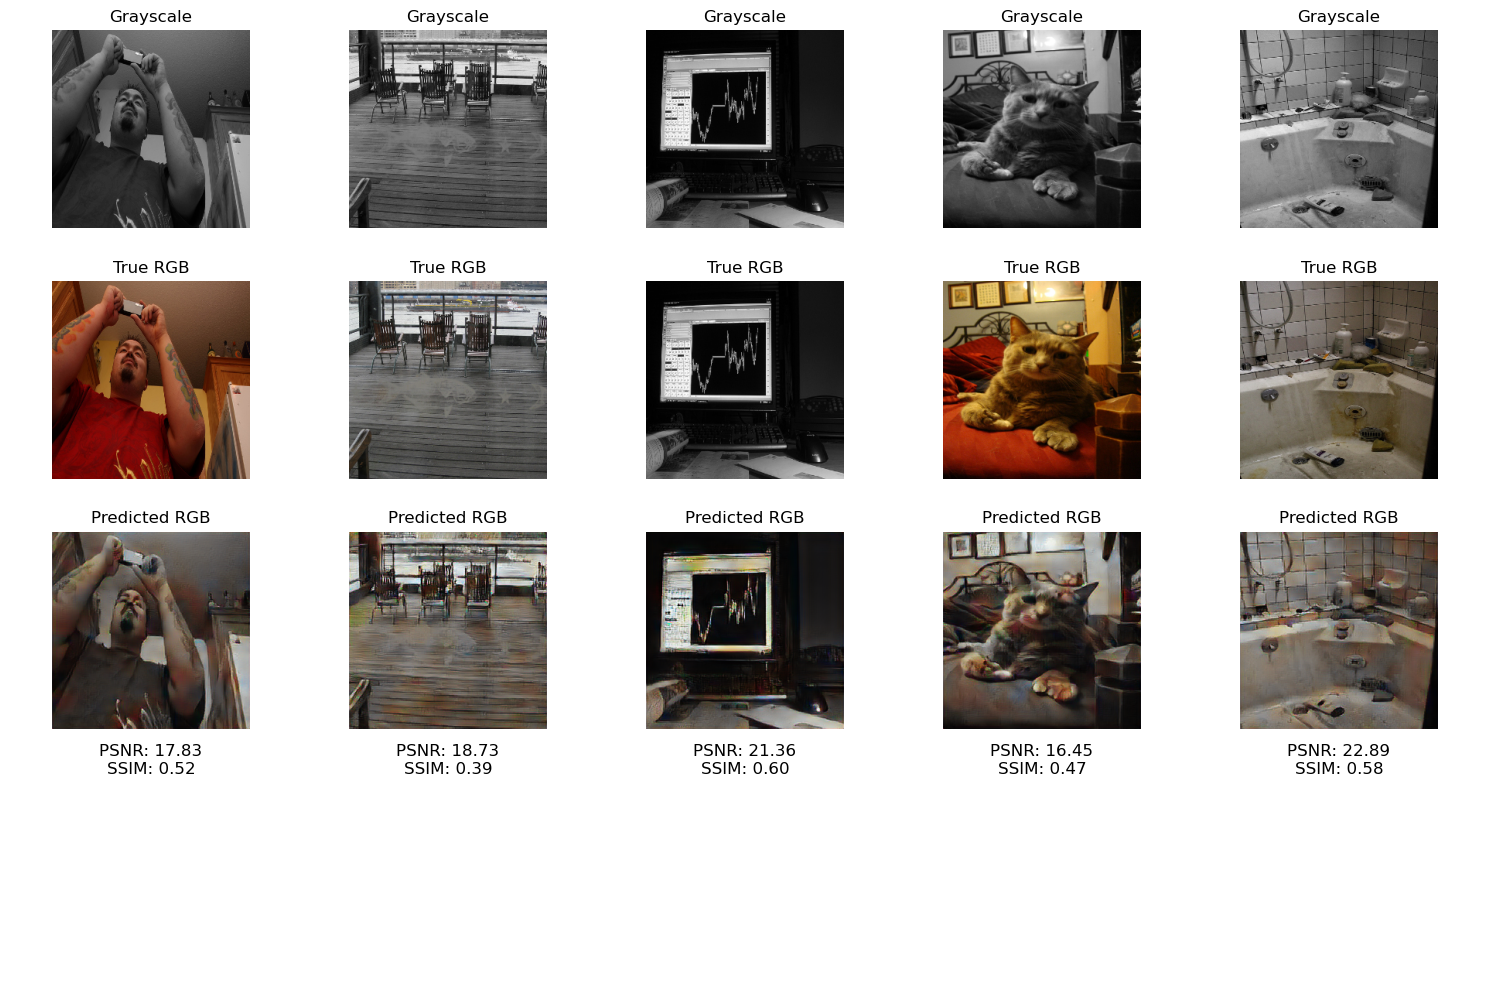

Average PSNR: 19.45
Average SSIM: 0.51


In [28]:
prediction_examples(saved_model, val_dataset)

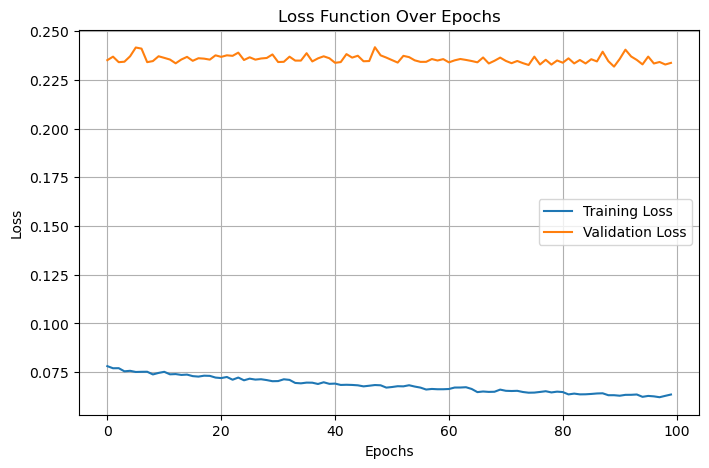

In [39]:

# Plot the loss function
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

In [19]:

def evaluate_model_on_validation(model, val_data):
    psnr_scores = []
    ssim_scores = []

    # Iterate over the entire validation dataset
    for grayscale_batch, rgb_batch in val_data:
        predicted_batch = model.predict(grayscale_batch)
        # Iterate through the batch
        for i in range(grayscale_batch.shape[0]):  
            true_image = rgb_batch[i].numpy()
            pred_image = np.clip(predicted_batch[i], 0, 1) 
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image, 
                pred_image, 
                channel_axis=-1, 
                data_range=1, 
                win_size=3  
            )

            psnr_scores.append(psnr)
            ssim_scores.append(ssim)
    mean_psnr = np.mean(psnr_scores)
    mean_ssim = np.mean(ssim_scores)
    print(f"Mean PSNR: {mean_psnr:.2f}")
    print(f"Mean SSIM: {mean_ssim:.2f}")

    return mean_psnr, mean_ssim

In [20]:
evaluate_model_on_validation(saved_model, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

(18.658084515641534, 0.5004011)

# Other Metrics than PSNR and SSIM

In [ ]:
from skimage.color import rgb2gray, rgb2lab
from skimage.restoration import estimate_sigma

# NIQE Calculation (Placeholder Example)
def calculate_niqe(image):
    """
    Calculate the NIQE score for an image.
    A placeholder logic using noise sigma as a proxy for demonstration.
    In practice, use a pre-trained NIQE model.
    """
    gray_image = rgb2gray(image)
    sigma = estimate_sigma(gray_image, average_sigmas=True)
    niqe_score = sigma
    return niqe_score

def calculate_colorfulness(image):
    """
    Calculate the colorfulness metric for an RGB image.
    """
    (R, G, B) = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    std_rg, mean_rg = np.std(rg), np.mean(rg)
    std_yb, mean_yb = np.std(yb), np.mean(yb)
    colorfulness = np.sqrt(std_rg**2 + std_yb**2) + 0.3 * np.sqrt(mean_rg**2 + mean_yb**2)
    return colorfulness

def calculate_brightness_contrast(image):
    """
    Calculate brightness and contrast for an image.
    Brightness is the mean luminance, and contrast is the standard deviation.
    """
    luminance = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    brightness = np.mean(luminance)
    contrast = np.std(luminance)

    return brightness, contrast

# LAB Color Balance Visualization
def analyze_color_balance(image):
    """
    Analyze the color balance of an image by visualizing LAB histograms.
    """
    lab_image = rgb2lab(image)
    L, a, b = lab_image[:, :, 0], lab_image[:, :, 1], lab_image[:, :, 2]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.hist(L.ravel(), bins=256, color='gray'); plt.title("Luminance (L)")
    plt.subplot(1, 3, 2); plt.hist(a.ravel(), bins=256, color='red'); plt.title("Chrominance (a)")
    plt.subplot(1, 3, 3); plt.hist(b.ravel(), bins=256, color='blue'); plt.title("Chrominance (b)")
    plt.tight_layout()
    plt.show()




In [ ]:
if __name__ == "__main__":
    from skimage import io

    # Load a sample image
    # image_url = 'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'
    # image = io.imread(image_url)
    image = rgb_images[1]
    # Ensure the image is normalized to range [0, 1]
    if image.max() > 1.0:
        image = image / 255.0

    # Calculate metrics
    niqe_score = calculate_niqe(image)
    colorfulness = calculate_colorfulness(image)
    brightness, contrast = calculate_brightness_contrast(image)

    # Display results
    print(f"NIQE Score: {niqe_score}")
    print(f"Colorfulness: {colorfulness}")
    print(f"Brightness: {brightness}")
    print(f"Contrast: {contrast}")

    analyze_color_balance(image)

# Model with Mask

In [ ]:
import matplotlib.pyplot as plt

def display_sample_images_with_mask(dataset, num_samples=5):
    """Displays a few examples of grayscale images, masks, and original images."""
    for (grayscale, mask), original in dataset.take(num_samples):
        for i in range(min(num_samples, grayscale.shape[0])):  # Handle batch
            # Convert tensors to numpy arrays
            grayscale_img = grayscale[i].numpy().squeeze()  # (128, 128, 1) -> (128, 128)
            mask_img = mask[i].numpy()
            original_img = original[i].numpy()

            # Plot the images
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_img, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("Mask")
            plt.imshow(mask_img)
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Original")
            plt.imshow(original_img)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

# Call the function on the dataset
display_sample_images_with_mask(colorization_dataset)


In [ ]:
from keras.layers import Concatenate, Input
from keras.models import Sequential, Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, BatchNormalization, Input
from keras.applications import VGG19
def build_colorization_model_with_mask(input_shape):
    # Inputs
    grayscale_input = Input(shape=input_shape, name="grayscale_input")  # (128, 128, 1)
    mask_input = Input(shape=(input_shape[0], input_shape[1], 3), name="mask_input")  # (128, 128, 3)

    # Concatenate grayscale and mask
    x = Concatenate()([grayscale_input, mask_input])  # (128, 128, 4)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final colorized output

    model = Model(inputs=[grayscale_input, mask_input], outputs=output)
    return model


In [ ]:
input_shape = (image_size[0], image_size[1], 1)  # Grayscale images have 1 channel
# Rebuild the model with the new input
model_mask = build_colorization_model_with_mask(input_shape)
model_mask.summary()
# Compile the model
model_mask.compile(optimizer='adam', loss= 'mse', metrics=['mae'])




In [ ]:
# Train the model
history = model_mask.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

In [ ]:
def predict_with_mask(model, grayscale_image, mask):
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  
    mask = np.expand_dims(mask, axis=0)  
    prediction = model.predict([grayscale_image, mask])
    return prediction[0]  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def predict_and_visualize(model, dataset):
    """Predicts and visualizes the results on a batch of data."""
    for (grayscale_batch, mask_batch), true_rgb_batch in dataset.take(1):
        predicted_rgb_batch = model.predict([grayscale_batch, mask_batch])

        psnr_scores = []
        ssim_scores = []

        plt.figure(figsize=(15, 10))

        # Display 5 examples
        for i in range(min(5, grayscale_batch.shape[0])):
            grayscale_image = grayscale_batch[i].numpy().squeeze()  # (128, 128, 1) -> (128, 128)
            mask_image = mask_batch[i].numpy()  # (128, 128, 3)
            true_rgb_image = true_rgb_batch[i].numpy()  # (128, 128, 3)
            predicted_rgb_image = np.clip(predicted_rgb_batch[i], 0, 1)  # (128, 128, 3)

            # Compute metrics
            psnr = peak_signal_noise_ratio(true_rgb_image, predicted_rgb_image, data_range=1)
            ssim = structural_similarity(
                true_rgb_image,
                predicted_rgb_image,
                channel_axis=-1,
                data_range=1,
                win_size=3
            )
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            plt.subplot(5, 5, i + 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_image, cmap='gray')
            plt.axis('off')

            plt.subplot(5, 5, i + 6)
            plt.title("Hint Mask")
            plt.imshow(mask_image)
            plt.axis('off')

            plt.subplot(5, 5, i + 11)
            plt.title("True RGB")
            plt.imshow(true_rgb_image)
            plt.axis('off')

            plt.subplot(5, 5, i + 16)
            plt.title("Predicted RGB")
            plt.imshow(predicted_rgb_image)
            plt.axis('off')

            plt.subplot(5, 5, i + 21)
            plt.title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        print(f"Average PSNR: {np.mean(psnr_scores):.2f}")
        print(f"Average SSIM: {np.mean(ssim_scores):.2f}")
        break  


In [ ]:
predict_and_visualize(model_mask, colorization_dataset)


In [ ]:
def evaluate_model_on_validation(model, val_data):
    psnr_scores = []
    ssim_scores = []

    # Iterate over the entire validation dataset
    for (grayscale_batch, mask_batch), rgb_batch in val_data:
        # Predict using the model
        predicted_batch = model.predict([grayscale_batch, mask_batch])

        # Iterate through the batch
        for i in range(grayscale_batch.shape[0]):
            true_image = rgb_batch[i].numpy()  # Ground truth
            pred_image = np.clip(predicted_batch[i], 0, 1)  # Ensure predictions are in [0, 1]

            # Compute PSNR and SSIM
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image,
                pred_image,
                channel_axis=-1,
                data_range=1,
                win_size=3
            )

            # Append scores
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

    # Compute mean scores
    mean_psnr = np.mean(psnr_scores)
    mean_ssim = np.mean(ssim_scores)

    print(f"Mean PSNR: {mean_psnr:.2f}")
    print(f"Mean SSIM: {mean_ssim:.2f}")

    return mean_psnr, mean_ssim
